In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gc
from tqdm import tqdm
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
import keras
from google.colab import files
import io
import os
import urllib.request
import zipfile
from functools import lru_cache



**Downloading the dataset from the link**

The function checks if the dataset is present; if not, it downloads and extracts it. This ensures data availability for processing without repeated downloads.

In [2]:
def download_dataset():
  urllib.request.urlretrieve(
    "https://go.criteois.com/criteo-research-attribution-dataset.zip",
    "criteo_attribution_dataset.zip"
  )

  with zipfile.ZipFile("criteo_attribution_dataset.zip", "r") as zip_ref:
    zip_ref.extractall("criteo_attribution_dataset")

In [3]:
dataset_path = 'criteo_attribution_dataset/criteo_attribution_dataset.tsv.gz'

if not os.path.exists(dataset_path):
  download_dataset()

#Using a subset sample of the dataset.
#Reason: The dataset size exceeds available memory, causing RAM overflow and application crashes

Reads in a sample (70% by default) of the dataset using a hashed user ID to keep user histories intact.

In [4]:
DEBUG_SAMPLE = 0.7

**We are selecting a subset sample, comprising 70% of the total dataset**

In [5]:
def get_sampled_dataset(debug_sample=0.7):
  """Get a dataset in which we sample on user ids to ensure we keep the entire histories
  """
  df = pd.read_csv(dataset_path, sep='\t', compression="gzip")
  uid_and_salt = df['uid'].astype(str) + 'hash_salt_for_sampling'
  hashed_uid_and_salt = pd.util.hash_pandas_object(uid_and_salt, index=False)
  random_column_based_on_uid = hashed_uid_and_salt / np.iinfo(np.uint64).max
  return df[random_column_based_on_uid < debug_sample]

df_criteo = get_sampled_dataset(DEBUG_SAMPLE)
df_criteo

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072
5,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,262565,30763035,9068207,9107790,29196072,32440044,1973606,2687461,29841067,21091108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16468022,2671199,5767906,4869923,0,-1,-1,0,1,-1,-1,...,482560,30763035,26597095,13113052,29196072,5824236,30763035,18391143,29196072,8661623
16468023,2671199,6852682,10002432,0,-1,-1,0,0,-1,-1,...,971748,25259032,9312274,10979162,29196072,32440044,29196072,27259439,29196072,8661620
16468024,2671199,16638720,7061828,0,-1,-1,0,0,-1,-1,...,268431,30763035,5824235,29542751,29196072,5824237,29196072,3696777,29196072,21091111
16468025,2671199,3032300,5061834,0,-1,-1,0,1,-1,-1,...,-1,1973606,26597096,28944164,29196072,26611392,1973606,5642940,14911188,29196072


In [ ]:
df_criteo = pd.read_csv(dataset_path, sep='\t', compression="gzip")

In [6]:
df_criteo.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072
5,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,262565,30763035,9068207,9107790,29196072,32440044,1973606,2687461,29841067,21091108


In [7]:
df_criteo.shape

(11516130, 22)

In [8]:
num_distinct_campaigns = df_criteo['campaign'].nunique()
print("Number of distinct campaigns:", num_distinct_campaigns)

Number of distinct campaigns: 675


In [9]:

n_campaigns = 500


In [10]:
df_criteo['day'] = np.floor (df_criteo['timestamp']/86400).astype(int)


Adds a jid column to uniquely identify journeys and normalizes time-related columns to a [0,1] range for standardized analysis.

In [12]:
#Creating a JourneylD column from UserlD and ConversionlD
def add_derived_columns(df):
    df_ext = df.copy()
    df_ext ['jid'] = df_ext['uid'].map(str) +'_'+ df_ext['conversion_id'].map(str)

    min_max_scaler = MinMaxScaler()

    for cname in ('timestamp','time_since_last_click'):
        x = df_ext[cname].values.reshape(-1,1)
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)

    return df_ext

In [13]:
df_criteo= add_derived_columns(df_criteo)

In [14]:
df_criteo.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat4,cat5,cat6,cat7,cat8,cat9,day,jid,timestamp_norm,time_since_last_click_norm
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,29196072,11409686,1973606,25162884,29196072,29196072,0,20073966_-1,0.000000e+00,0.000000
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,29196072,5824237,138937,1795451,29196072,15351056,0,28474333_-1,7.487274e-07,0.003426
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,23549932,5824237,1973606,9180723,29841067,29196072,0,7306395_3063962,1.123091e-06,0.000000
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,29196072,11409684,26597096,4480345,29196072,29196072,0,25357769_-1,1.123091e-06,0.000000
5,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,29196072,32440044,1973606,2687461,29841067,21091108,0,93907_-1,1.497455e-06,0.101299


In [15]:
np.random.seed(42)
def sample_campaigns(df,n_campaigns):
  campaigns = np.random.choice(df_criteo['campaign'].unique(),n_campaigns,replace=False)
  return df[df['campaign'].isin(campaigns)]


In [16]:
#Calling the sample_campaigns function with n_campaigns=400
df_criteo = sample_campaigns(df_criteo,n_campaigns)

In [17]:
df_criteo.shape

(8761116, 26)

**Ensures that only journeys with at least the specified number of touchpoints are retained.**

In [18]:
def filter_journeys_by_length(df,min_touchpoints) :
  if min_touchpoints <= 1:
    return df
  else :
    grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
    return df[df['jid'].isin(grouped[grouped['count'] >= min_touchpoints] ['jid'].values)]

In [19]:
#Calling the filter journeys_by_length function
df_criteo = filter_journeys_by_length(df_criteo, 2)
#Displaying the structure of the datasetd

**Balances the dataset by undersampling the majority class (non-conversions) for a balanced representation.**

In [20]:
def balance_conversions(df):
    df_minority = df [df.conversion == 1]
    df_majority = df [df.conversion == 0]

    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0])

    df_majority_sampled = pd.DataFrame(data=None, columns=df. columns)

    for jid_chunk in df_majority_jids:
      df_majority_sampled = pd. concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
      if df_majority_sampled.shape[0] > df_minority.shape [0]:
        break
      return pd.concat([df_majority_sampled,df_minority]).sample(frac=1).reset_index(drop=True)


In [21]:
df_criteo = balance_conversions(df_criteo)

<ipython-input-20-e4b9469fd8d2>:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_majority_sampled = pd. concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])


In [22]:
df_criteo.shape

(303671, 26)

The map_one_hot function is designed to create a one-hot encoding of specified categorical columns, combining them into a single array column.This function will allow your model to interpret categorical data (e.g., campaigns, cat1, cat2, etc.) as numerical arrays, which is essential for many machine learning algorithms and for directly counting and tracking each campaign’s presence.

In [23]:
def map_one_hot(df, column_names, result_column_name):
    mapper = {}
    for i, col_name in enumerate(column_names):
      for val in df[col_name].unique():
        mapper[str(val) + str(i)] = len(mapper)

    df_ext = df.copy()

    def one_hot (values):
      v = np.zeros(len(mapper))
      for i, val in enumerate(values):
        v[mapper[str(val) + str(i)]] = 1
      return v

    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)

    return df_ext


In [24]:
df_criteo = map_one_hot(df_criteo,['cat1','cat2','cat3','cat4','cat5','cat6','cat8'], 'cats')

In [25]:
df_criteo.cats[0]

array([1., 0., 0., ..., 0., 0., 0.])

In [26]:
df_criteo = map_one_hot(df_criteo,['campaign'],'campaigns').sort_values(by=['timestamp_norm'])


In [27]:
df_criteo.shape

(303671, 28)

In [29]:
[df_criteo[df_criteo.conversion == 0].shape[0], df_criteo[df_criteo.conversion == 1].shape[0]]


[5027, 298644]

In [30]:
df_criteo.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat6,cat7,cat8,cat9,day,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
13804,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,26597096,4480345,29196072,29196072,0,25357769_-1,0.000001,0.000000,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12591,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,1973606,9180723,29841067,29196072,0,7306395_3063962,0.000001,0.000000,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
137673,4,19923387,31772643,0,-1,-1,0,0,-1,-1,...,32440041,14074087,29196072,21091108,0,19923387_-1,0.000001,0.069316,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
191520,7,23074162,16184517,0,-1,-1,0,0,-1,-1,...,1973606,17737135,9312274,29196072,0,23074162_-1,0.000003,0.000000,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
258702,7,5588915,27491436,0,-1,-1,0,0,-1,-1,...,29196072,21857352,29196072,29196072,0,5588915_-1,0.000003,0.000000,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [31]:
df_criteo.campaign.unique()

array([13365547, 29427842, 31772643, 16184517, 27491436, 21640043,
       24267774, 18443077, 13462155, 1415896, 10341182, 27684173, 9100689,
       32135670, 13422843, 2946551, 4869922, 25064375, 15184511, 13289562,
       2144729, 24045148, 5061834, 32452111, 30491418, 16922675, 25419531,
       9106407, 13661605, 2953716, 497590, 3291800, 497593, 5544859,
       27888153, 17661711, 14661605, 24378636, 13661597, 1586481,
       22589171, 31736975, 17288254, 12947794, 1341195, 24126625, 8877963,
       30427825, 32452108, 8892339, 32368244, 9100693, 15398570, 28739284,
       20309767, 3884873, 12351511, 30801593, 30405203, 12700454,
       27031690, 22431924, 21830168, 22891668, 29614012, 28729624,
       26852339, 11803618, 14289571, 2077112, 13947793, 14121532,
       11500306, 7877971, 13947795, 9100690, 30881002, 2694554, 31330666,
       25259856, 7289590, 28328731, 24389111, 14102485, 289466, 27891651,
       29534051, 7686710, 27118781, 15568932, 23817046, 19129839,
       238

In [32]:
df_criteo.campaigns[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

**The journey_length_histogram function calculates and returns the distribution of journey lengths (number of touchpoints) for each journey ID (jid) in the dataset.**

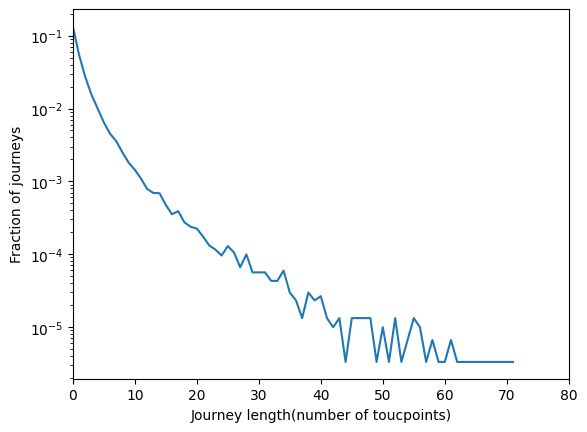

In [35]:
def journey_length_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts. values / df.shape[0]

hist_x,hist_y= journey_length_histogram(df_criteo)

plt.plot (range(len(hist_x)),hist_y,label = 'all journeys')
plt.yscale('log')
plt.xlim (0, 80)
plt.xlabel('Journey length(number of toucpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

## ***Linear Attribution Model***

linear attribution model function assigns equal credit to each touchpoint in a customer journey leading up to a conversion. This model assumes that all interactions contribute equally to the final outcome (conversion), regardless of when they occurred in the journey.

In [38]:

# Defining the linear attribution function
def linear_attribution(df):
    # Counting Impressions by Campaign
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)

        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)  # Find the index of the campaign
            counters[campaign_id] += 1
        return counters

    # Calculate Campaign Impressions
    campaign_impressions = count_by_campaign(df)

    # Filter for Conversions and Calculate Conversion Rate per Click
    df_converted = df[df['conversion'] == 1].copy()  # Filter rows where conversion == 1
    df_converted['linear'] = df_converted['conversion'] / df_converted['click_nb'].astype(float)

    # Counting Conversions by Campaign
    def linear_attribution_by_campaign(df_conv):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_conv)):
            campaign_id = np.argmax(df_conv.iloc[idx]['campaigns'])
            counters[campaign_id] += df_conv.iloc[idx]['linear']
        return counters

    # Calculate Conversion Attribution
    campaign_conversions = linear_attribution_by_campaign(df_converted)

    return campaign_conversions / campaign_impressions  # Conversion rate per impression

# Example Usage
# Ensure df_criteo is defined and that n_campaigns = 400 is defined outside
linear_attr = linear_attribution(df_criteo)


<ipython-input-38-58692e882100>:30: RuntimeWarning: invalid value encountered in divide
  return campaign_conversions / campaign_impressions  # Conversion rate per impression


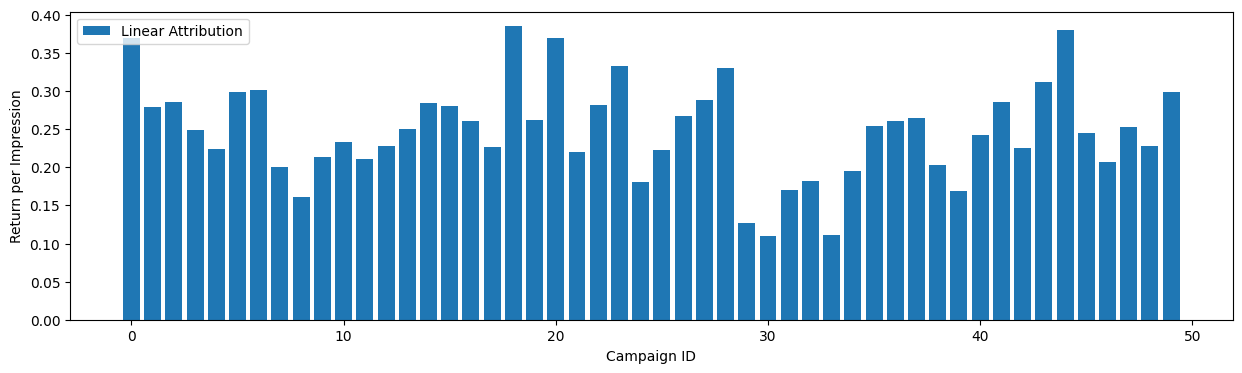

In [39]:
campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15, 4))
plt.bar(range(len(linear_attr[campaign_idx])), linear_attr[campaign_idx], label='Linear Attribution')
plt.ylabel('Return per Impression')
plt.xlabel('Campaign ID')
plt.legend(loc='upper left')
plt.show()


**This model helps evaluate how effectively each campaign contributes to conversions, based on equal credit distribution across all campaigns in a conversion path.**

In [40]:
linear_attr

array([0.23340841, 0.22983208, 0.29486157, 0.3075    , 0.2178867 ,
       0.20951803, 0.16876965, 0.27150698, 0.2192458 , 0.22622844,
       0.21686362, 0.13581444, 0.26589145, 0.18161339, 0.25130459,
       0.24649799, 0.21021983, 0.1948788 , 0.26680418, 0.27242651,
       0.24122533, 0.20369879, 0.31638142, 0.19890074, 0.2378169 ,
       0.16195288, 0.18256641, 0.33827331, 0.25353594, 0.19843847,
       0.19398011, 0.18983075, 0.32618243, 0.27650473, 0.24832442,
       0.2819578 , 0.25761515, 0.25887586, 0.21530661, 0.12106814,
       0.26975309, 0.29639724, 0.25988846, 0.22815515, 0.1898937 ,
       0.18886827, 0.28745179, 0.25792877, 0.18893514, 0.23624225,
       0.21927821, 0.22246052, 0.16182725, 0.22879608, 0.19810268,
       0.37167987, 0.31578406, 0.2989202 , 0.36508196, 0.23681439,
       0.2932392 , 0.37137214, 0.20541   , 0.17752564, 0.2351666 ,
       0.25257775, 0.36474608, 0.37795326, 0.14026171, 0.18106128,
       0.13572236, 0.35388331, 0.19038236, 0.17467978, 0.26875

#Time Decay Attribution Model

Time-decay attribution gives more credit to the touchpoints that are closer in time to the conversion.

The time decay formula used here is
**2^(-X/half life)**

where X = Conversion day - Click day and half life =7


**Creating the conversion day column**

In [41]:
df_criteo['conversion_day'] = np.floor(df_criteo.conversion_timestamp/86400).astype(int)

In [42]:
df_criteo.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'day', 'jid', 'timestamp_norm',
       'time_since_last_click_norm', 'cats', 'campaigns', 'conversion_day'],
      dtype='object')

In [43]:
df_criteo.shape

(303671, 29)

**Creating a function for time decay attribution model**

Implements a time decay attribution model, assigning greater weight to interactions closer to the conversion. The model computes decay using the exponential formula
2−(days difference/7)

In [46]:
def time_decay_attribution(df):
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)  # Ensure n_campaigns is defined
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters

    campaign_impressions = count_by_campaign(df)

    df_converted = df[df['conversion'] == 1]

    def calculate_attribution(conversion_day, click_day):
        rel_pos = conversion_day - click_day
        attribution = pow(2, -(rel_pos / 7))
        return attribution

    def time_decay_attribution_value(df_converted):
        df_converted['time_decay'] = df_converted.apply(
            lambda val: calculate_attribution(val.conversion_day, val.day),
            axis=1  # Specify axis for apply
        )
        return df_converted

    def time_decay_by_campaign(df_converted):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_converted)):
            campaign_id = np.argmax(df_converted.iloc[idx, 27])
            counters[campaign_id] += df_converted.iloc[idx, 29]
        return counters

    df_converted = time_decay_attribution_value(df_converted)

    campaign_conversions = time_decay_by_campaign(df_converted)
    return campaign_conversions / campaign_impressions  # Return the final result


time_decay_attr = time_decay_attribution(df_criteo)


<ipython-input-46-a0f33238b760>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_converted['time_decay'] = df_converted.apply(
<ipython-input-46-a0f33238b760>:35: RuntimeWarning: invalid value encountered in divide
  return campaign_conversions / campaign_impressions  # Return the final result


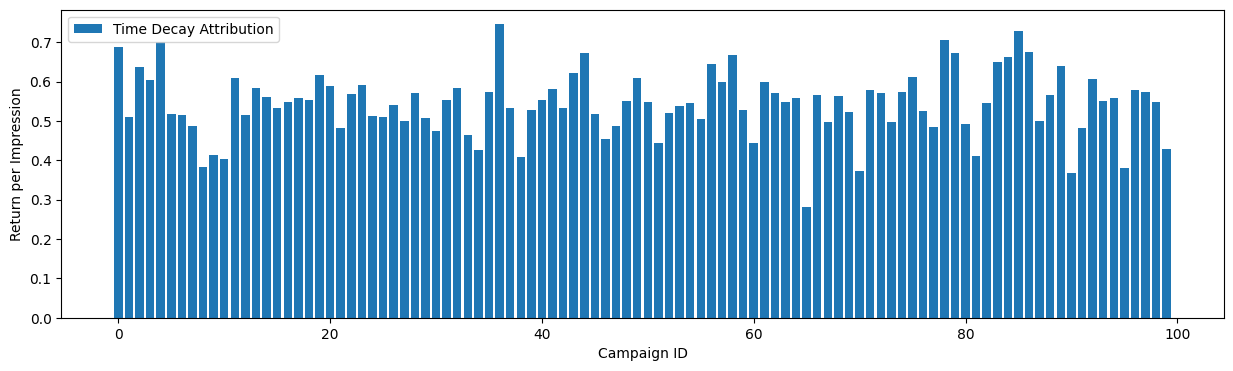

In [47]:
campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15, 4))
plt.bar(range(len(time_decay_attr[campaign_idx])), time_decay_attr[campaign_idx], label='Time Decay Attribution')
plt.ylabel('Return per Impression')  # Fixed quotation mark
plt.xlabel('Campaign ID')  # Fixed quotation mark
plt.legend(loc='upper left')

# Display the plot
plt.show()


**Plotting a graph to visualize the attribution scores**

Plotting the time decay attribution scores for a specific range of campaigns, providing insights into campaign performance.



In [48]:
time_decay_attr

array([0.56875054, 0.49205425, 0.54794929, 0.51388499, 0.53952492,
       0.47340834, 0.60794914, 0.57067825, 0.46586916, 0.53138059,
       0.51211189, 0.5751001 , 0.60018226, 0.50685773, 0.41985446,
       0.51725949, 0.50835472, 0.51930287, 0.69201532, 0.52505834,
       0.56402795, 0.5226361 , 0.55606818, 0.50748454, 0.5109376 ,
       0.4796756 , 0.65403502, 0.6449022 , 0.50211706, 0.49294094,
       0.50581242, 0.60084091, 0.58893691, 0.57939261, 0.48308042,
       0.50858761, 0.57843195, 0.49652716, 0.51679704, 0.47838975,
       0.5251264 , 0.4935041 , 0.47336475, 0.48641537, 0.49301184,
       0.50729907, 0.51273811, 0.62699696, 0.53421598, 0.49335436,
       0.51128105, 0.47589634, 0.58531341, 0.6145256 , 0.48406957,
       0.7742282 , 0.53094698, 0.54058818, 0.65353496, 0.524965  ,
       0.4740638 , 0.79139847, 0.48352138, 0.54059723, 0.50671778,
       0.50436241, 0.63872278, 0.84459437, 0.51198009, 0.52051868,
       0.48656952, 0.56495883, 0.45560871, 0.50054729, 0.68317